## Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import keras
import tqdm
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import sklearn

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
#from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [7]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)
print("PIL version:", Image.__version__)
print("scikit-learn version:", sklearn.__version__)

pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.8.3
seaborn version: 0.13.2
tensorflow version: 2.17.0
keras version: 3.4.1
PIL version: 10.2.0
scikit-learn version: 1.4.1.post1


## Load the Dataset

In [8]:
TRAIN_DIR = 'face_images/train/'
TEST_DIR = 'face_images/test/'

In [9]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,face_images/train/angry\Training_20445632.jpg,angry
1,face_images/train/sad\Training_26010996.jpg,sad
2,face_images/train/sad\Training_91959406.jpg,sad
3,face_images/train/neutral\Training_45495964.jpg,neutral
4,face_images/train/neutral\Training_58848349.jpg,neutral


In [11]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,face_images/test/angry\PrivateTest_10131363.jpg,angry
1,face_images/test/angry\PrivateTest_10304478.jpg,angry
2,face_images/test/angry\PrivateTest_1054527.jpg,angry
3,face_images/test/angry\PrivateTest_10590091.jpg,angry
4,face_images/test/angry\PrivateTest_1109992.jpg,angry


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

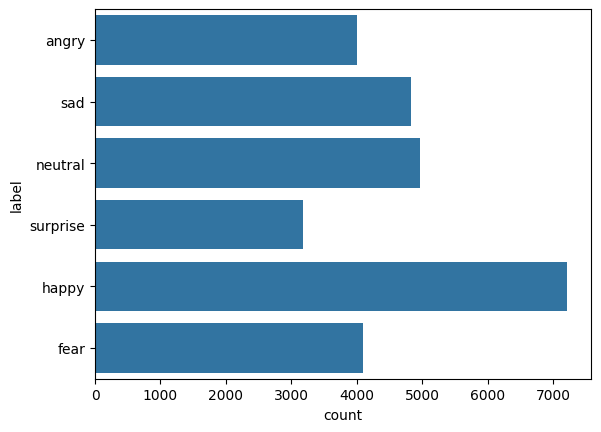

In [12]:
sns.countplot(train['label'])

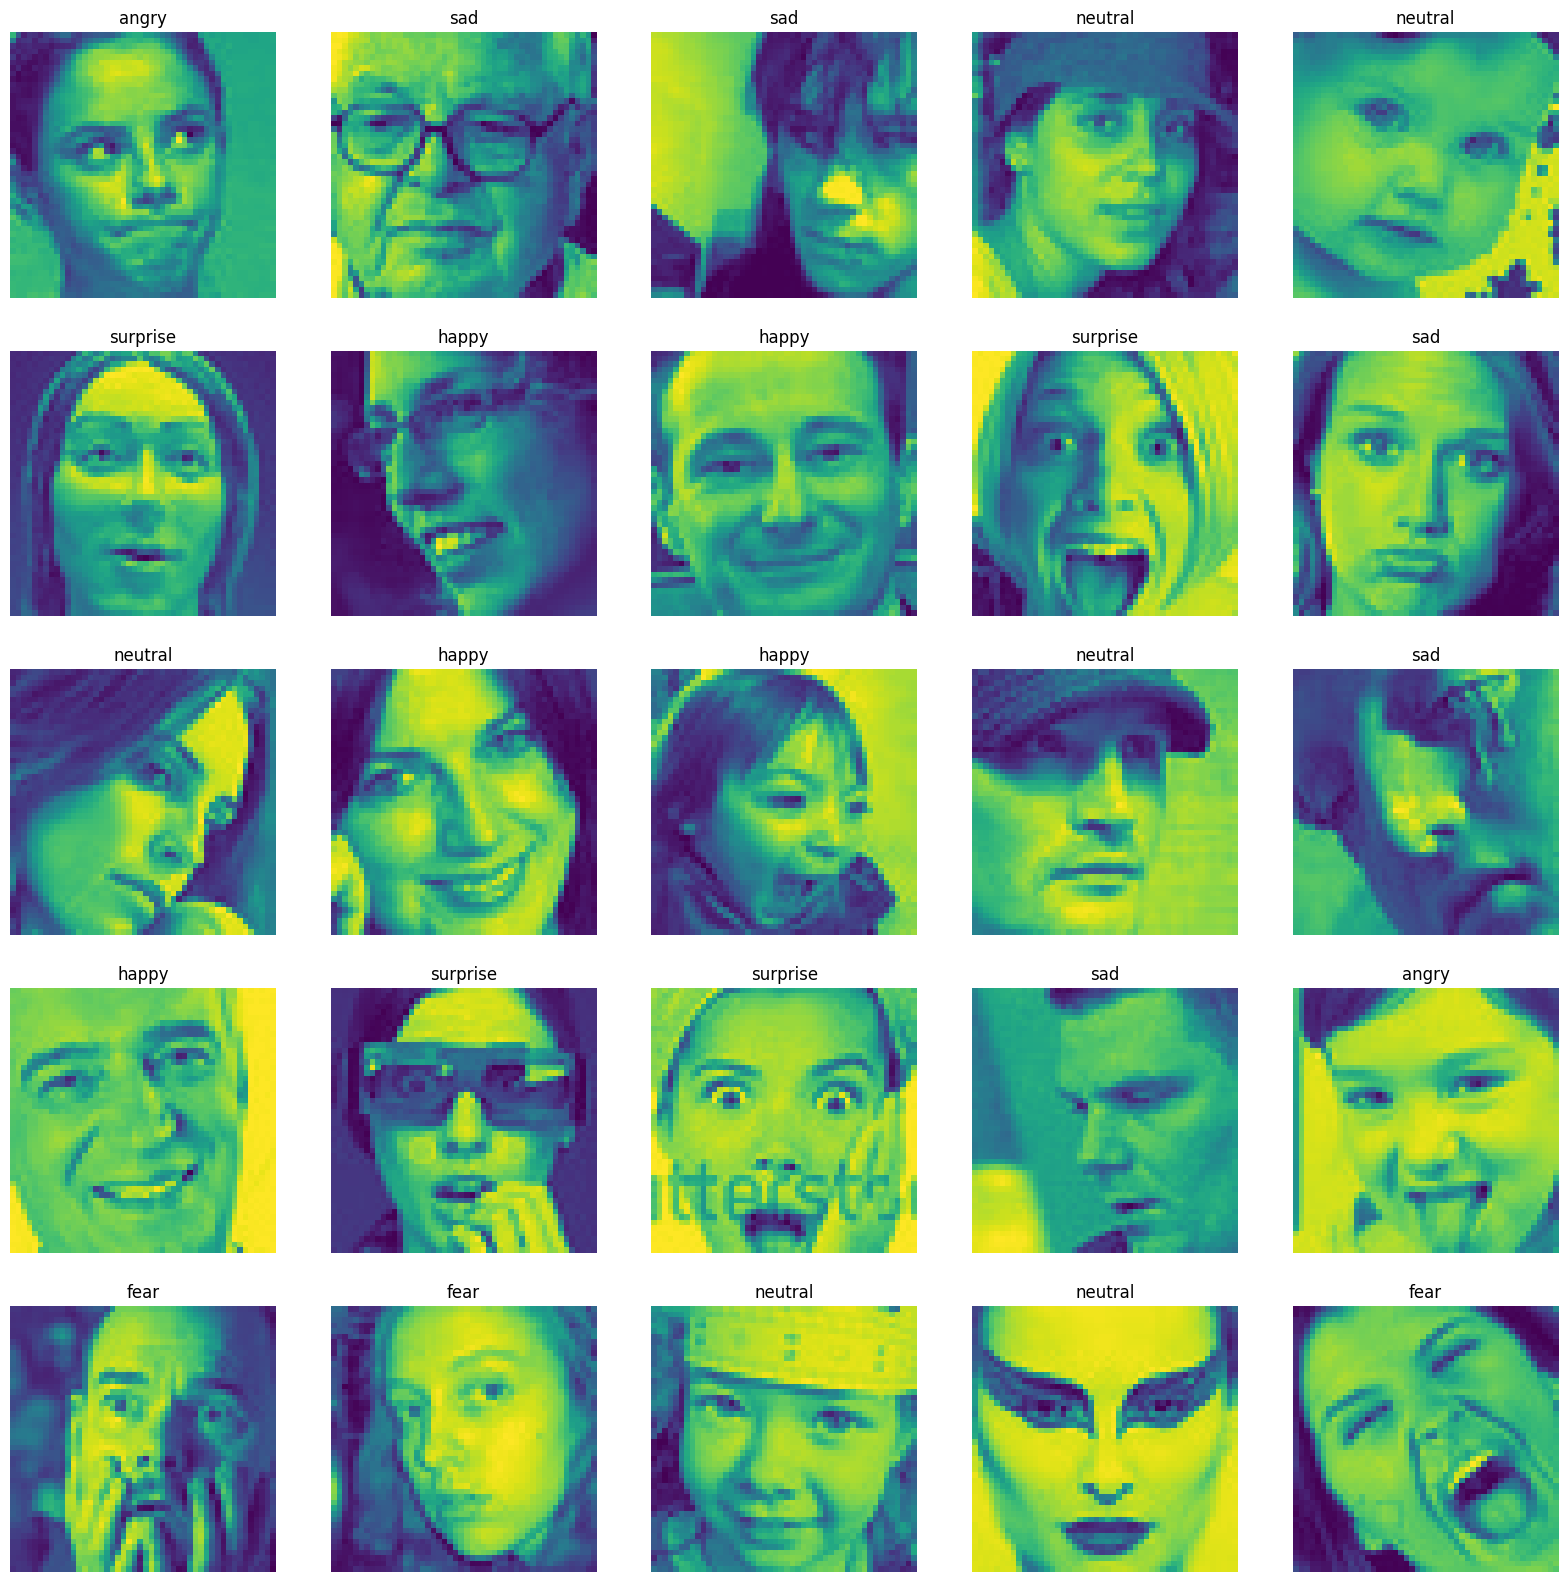

In [13]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = Image.open(file)  # Replace load_img with Image.open
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert("L").resize((48, 48))  # Convert to grayscale and resize
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Ensure correct shape
    return features

In [15]:
train_features = extract_features(train['image'])

  0%|          | 0/28273 [00:00<?, ?it/s]

In [16]:
test_features = extract_features(test['image'])

  0%|          | 0/7067 [00:00<?, ?it/s]

In [17]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [18]:
## convert label to integer
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

# Convert integers to one-hot encoded vectors
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [19]:
# Verify the shape and content of the transformed labels
print(y_train.shape)  # Should be (number of samples, num_classes)
print(y_train[0])
print(train_features.shape)

(28273, 6)
[1. 0. 0. 0. 0. 0.]
(28273, 48, 48, 1)


In [20]:
# config
input_shape = (48, 48, 1)
output_class = 6

## Model Creation

In [21]:
model = Sequential()
# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# Output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,231,942 (16.14 MB)

 Trainable params: 4,231,942 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# train the model
history = model.fit(x=x_train,
                    y=y_train, 
                    batch_size=128, 
                    epochs=5, 
                    validation_data=(x_test, y_test))

Epoch 1/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.2536 - loss: 1.7670 - val_accuracy: 0.2510 - val_loss: 1.7620
Epoch 2/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.2564 - loss: 1.7581 - val_accuracy: 0.2509 - val_loss: 1.7606
Epoch 3/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.2642 - loss: 1.7337 - val_accuracy: 0.3276 - val_loss: 1.6280
Epoch 4/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.3171 - loss: 1.6329 - val_accuracy: 0.4037 - val_loss: 1.4859
Epoch 5/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3967 - loss: 1.5020 - val_accuracy: 0.4514 - val_loss: 1.3765


## Plot the Results

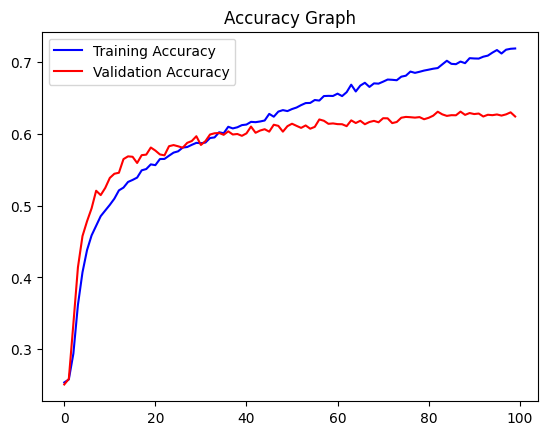

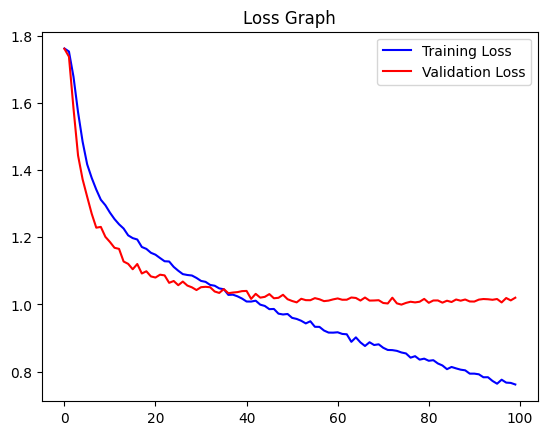

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Output: fear


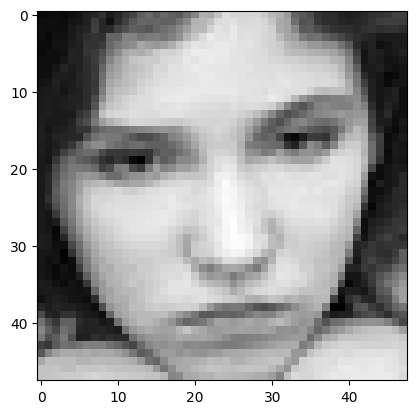

In [45]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [46]:
import pickle

In [47]:
pickle.dump(model, open('model_image.pkl','wb')) 

In [23]:
import os
import cv2  # OpenCV for image processing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [24]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)

    return image_paths, labels

In [25]:
# Load dataset
train_images, train_labels = load_dataset(TRAIN_DIR)
test_images, test_labels = load_dataset(TEST_DIR)

print("Total train images:", len(train_images))
print("Total test images:", len(test_images))

Total train images: 28273
Total test images: 7067


In [26]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (48, 48))  # Resize to 48x48
        
        # Flatten the image pixels into a single feature vector
        img = img.flatten()
        features.append(img)
    
    return np.array(features)

In [27]:
# Extract features from training and test images
x_train = extract_features(train_images)
x_test = extract_features(test_images)

  0%|          | 0/28273 [00:00<?, ?it/s]

  0%|          | 0/7067 [00:00<?, ?it/s]

In [28]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

In [29]:
# Convert labels to numerical values
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

In [30]:
print("Feature shape:", x_train.shape)  # Should be (num_samples, num_features)

Feature shape: (28273, 2304)


In [31]:
pca = PCA(n_components=100)  # Reduce to 100 principal components
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print("PCA Reduced Feature Shape:", x_train_pca.shape)

PCA Reduced Feature Shape: (28273, 100)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Define models
svm_model = SVC(kernel='linear', probability=True)  # Support Vector Machine
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest
lr_model = LogisticRegression(max_iter=500, random_state=42)  # Logistic Regression
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  # Gradient Boosting

# Train models
print("Training SVM...")
svm_model.fit(x_train, y_train)

#print("Training Random Forest...")
#rf_model.fit(x_train, y_train)

#print("Training Logistic Regression...")
#lr_model.fit(x_train, y_train)

#print("Training Gradient Boosting...")
#gbc_model.fit(x_train, y_train)

print("All models trained successfully!")

In [ ]:
# Define function to evaluate models
def evaluate_model(model, name):
    preds = model.predict(x_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))
    print("-" * 50)

# Evaluate all models
evaluate_model(svm_model, "Support Vector Machine (SVM)")
evaluate_model(rf_model, "Random Forest (RF)")
evaluate_model(lr_model, "Logistic Regression (LR)")
evaluate_model(gbc_model, "Gradient Boosting Classifier (GBC)")


In [ ]:
# Collect accuracies
model_names = ["SVM", "Random Forest", "Logistic Regression", "Gradient Boosting"]
accuracies = [
    accuracy_score(y_test, svm_model.predict(x_test)),
    accuracy_score(y_test, rf_model.predict(x_test)),
    accuracy_score(y_test, lr_model.predict(x_test)),
    accuracy_score(y_test, gbc_model.predict(x_test)),
]

# Plot performance
plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Machine Learning Models")
plt.ylim(0, 1)
plt.show()
